In [1]:
using PyPlot

In [1]:
# from https://github.com/JuliaLang/julia/blob/master/examples/ndgrid.jl
function meshgrid{T}(vx::AbstractVector{T}, vy::AbstractVector{T})
  m, n = length(vy), length(vx)
  vx = reshape(vx, 1, n)
  vy = reshape(vy, m, 1)
  (repmat(vx, m, 1), repmat(vy, 1, n))
end

meshgrid (generic function with 1 method)

In [1]:
type Intercept
    v
    ϵ
    rₑ
    λ
end

In [2]:
kerbinRadius = 600000.0
munRadius    = 200000.0
munSOI       = 2429559.6
munAltitude  = 12000000.0
muKerbin     = 3.5315984e12
muMun        = 6.5138398e10
vMun         = 542.5   #speed of mun's orbit
ωₘ           = vMun/munAltitude

4.520833333333333e-5

In [3]:
#r0: departure altitude, v0: departure speed, ϕ₀: departure angle, λ: mun arrival angle
function lunarInterceptBate(r0,v0,ϕ₀,λ)
    #want to find velocity vector at lunar intercept
    E = v0^2/2 - muKerbin/r0
    h = r0*v0*cos(ϕ₀)
    r1 = 0
    v1 = 0
    ϕ₁ = 0
    γ₁ = 0
    try
        r1 = sqrt(munAltitude^2+munSOI^2-2*munAltitude*munSOI*cos(λ))
        v1 = sqrt(2*(E+muKerbin/r1))
        ϕ₁ = acos(h/(r1*v1))
        γ₁ = asin(munSOI/r1*sin(λ))
    catch error
        return Intercept(-1,0,0,0)
    end
    
    #fully specified parameters of the Munar orbit
    r2 = munSOI
    v2 = sqrt(v1^2+vMun^2-2*v1*vMun*cos(ϕ₁-γ₁))   #speed at intercept in Mun frame
    ϵ₂ = asin(vMun/v2*cos(λ)-v1/v2*cos(λ+γ₁-ϕ₁))  #negative sometimes
    
    return Intercept(v2,ϵ₂,r1,λ)
end

lunarInterceptBate (generic function with 1 method)

In [4]:
#returns the lunar periapsis of a given lunar intercept
function lunarPeriapsis(k)
    v2 = k.v
    if v2<0
        return munSOI
    end
    ϵ₂ = k.ϵ   
    r2 = munSOI
    E₂ = v2^2/2-muMun/r2
    h₂ = r2*v2*sin(ϵ₂)
    p = h₂^2/muMun
    ecc = sqrt(1+2*E₂*h₂^2/muMun^2)
    rₚ = p/(1+ecc)                 #wow! ecc here used to be just e=2.718...! big effect!!
    
    return rₚ
end

lunarPeriapsis (generic function with 1 method)

In [5]:
#TODO find a way to reuse code from lunarPeriapsis - most of this is copied
#key stuff derived from https://en.wikipedia.org/wiki/Hyperbola#Polar_coordinates
function lunarDeflectionAngle(intercept)
    v2 = intercept.v
    if v2<0
        return munSOI
    end
    ϵ₂ = intercept.ϵ
    r2 = munSOI
    E₂ = v2^2/2-muMun/r2
    h₂ = r2*v2*sin(ϵ₂)
    p = h₂^2/muMun
    ecc = sqrt(1+2*E₂*h₂^2/muMun^2)
    #println("Lunar orbit parameter: ", round(p, 3),",  ecc: ",round(ecc,3))
    interceptToPeriapsisAngle = 0
    try
        interceptToPeriapsisAngle = acos((1-p/munSOI)/ecc)
    catch e
        return 0
    end
    return 2*interceptToPeriapsisAngle     #Interior angle between the asymptotes as measured from the Mun's center
end

lunarDeflectionAngle (generic function with 1 method)

In [6]:
#angle formed by craft exit position, mun's center, and kerbin's position at intercept
#only considers typical free return orbits - approaching from below
function lunarExitAngle(intercept, entryAngle)
    deflection = lunarDeflectionAngle(intercept)
    ϵ = intercept.ϵ
    if ϵ > 0
        return entryAngle+deflection
    else
        return entryAngle-deflection
    end
end
        

lunarExitAngle (generic function with 1 method)

In [7]:
#Speed in kerbin frame after mun encounter
function lunarExitSpeed(intercept, exitAngle, tof)
    ω = vMun/munAltitude
    θ = exitAngle-intercept.ϵ + tof*ω - pi/2
    θ = pi-θ
    v = sqrt(intercept.v^2 + vMun^2 - 2*intercept.v*vMun*cos(θ))
    ϕ = asin(intercept.v/v*sin(θ))
    
    rₓ⁰ = sqrt(munAltitude^2+munSOI^2-2*munAltitude*munSOI*cos(2pi-(exitAngle)))
    rₓ¹ = sqrt(munAltitude^2+munSOI^2-2*munAltitude*munSOI*cos(2pi-(exitAngle+tof*ω)))
    #δ: mun-kerbin-craft angle @exit
    δ = asin(sin(2pi - exitAngle - tof*ω)*munSOI/rₓ¹)
    println("δ: $δ")
    println("ϕ: $ϕ")
    β = ϕ+pi/2-δ #replace pi-θ with angle between v_kf and v_mun
    println("β: $β")
    #gives correct actual exit height!
    
    println("Exit height: ", rₓ¹)
    println("Exit radial speed: ", -v*cos(β))
    
    E₂ = v^2/2-muKerbin/rₓ¹
    h = rₓ¹*v*sin(β)
    p = h^2/muKerbin
    ecc = sqrt(1+2*E₂*h^2/muKerbin^2)
    rₚ = p/(1+ecc)       
    
    println("Periapsis: ", rₚ)
    
    return v
end

lunarExitSpeed (generic function with 1 method)

In [8]:
#https://en.wikipedia.org/wiki/True_anomaly#Radius_from_true_anomaly
function trueAnomalyAtIntercept(a, ecc, r)
    return acos(((a/r*(1-ecc^2))-1)/ecc)
end

function smallAngle(r,λ)
    return asin(munSOI/r*sin(λ))
end

smallAngle (generic function with 1 method)

In [9]:
function timeOfFlight(r,a,ecc)
    E = acos((1-r/a)/ecc)
    tof = sqrt(a^3/muKerbin)*(E-ecc*sin(E))
    return tof
end

timeOfFlight (generic function with 1 method)

In [10]:
function lunarToF(intercept,rₚ)
    a = 1/((intercept.v^2/muMun-2/munSOI))
    ν = asin(1/(1+rₚ/a))
    H = acosh((1+munSOI/a)*sin(ν))
    return 2*sqrt(a^3/muMun)*(csc(ν)sinh(H)-H)
end

lunarToF (generic function with 1 method)

In [11]:
v0 = 3100
r0 = 700000
λ = .86
t=140000

E = v0^2/2-muKerbin/r0
a = -muKerbin/(2*E)
munInt = lunarInterceptBate(r0,v0,0.0001,λ)
rₚ= lunarPeriapsis(munInt)
munToF = lunarToF(munInt, rₚ)
exitAngle = lunarExitAngle(munInt, λ)

println("Mun ToF: ", munToF)
println("Exit speed: ", lunarExitSpeed(munInt, exitAngle, munToF))
println("Munar periapsis: ", round(rₚ-munRadius), "m above surface")

print("Orbit params: e=", round(1-r0/a,6),", a=",round(a,1),"\n")

ecc = 1-r0/a
interceptRadius = sqrt(munAltitude^2+munSOI^2-2*munAltitude*munSOI*cos(λ))

interceptTrueAnomaly = trueAnomalyAtIntercept(a, ecc, interceptRadius)
delta = smallAngle(interceptRadius, λ)
munPosition = 1.7
ToF = timeOfFlight(interceptRadius,a,ecc)

#println("Intercept at ", round(interceptRadius), "m and true anomaly ", interceptTrueAnomaly, "r");
println("Argument of periapsis: ", round((munPosition+delta-interceptTrueAnomaly)*180/pi,4))
println("Time of flight: ", ToF, "s")
#println("Time spent around Mun: ", munToF)
#printSpeeds(r0,v0,0.0001,λ)

#print("run tothemun.ks(", round(a,1), ",",round(orbitAngle,4),",",1400000,").")

Mun ToF: 9841.656368051197
δ: 0.15941028704144986
ϕ: -0.8724242512983242
β: 0.5389617884551224
Exit height: 1.0339749657127876e7
Exit radial speed: -414.39798179265705
Periapsis: 992304.530620256
Exit speed: 482.84514314269865
Munar periapsis: 26791.0m above surface
Orbit params: e=0.904803, a=7.3531898e6
Argument of periapsis: -57.5611
Time of flight: 13634.256881793024s
Time spent around Mun: 9841.656368051197


Got a, e, and AoP all worked out. Just need periapsis epoch time. For an intercept at t=0 (like we have above), epoch time is -ToF. In HyperEdit just set Mean Anomaly at Epoch to 0 and Epoch to -ToF.

Need to figure out how to handle those orbits that reach the Mun on the downward part ($\nu > \pi$)

In [10]:
#r0: departure altitude, v0: departure speed, ϕ₀: departure angle, λ: mun arrival angle
function printSpeeds(r0,v0,ϕ₀,λ)
    #want to find velocity vector at lunar intercept
    E = v0^2/2 - muKerbin/r0
    h = r0*v0*cos(ϕ₀)
    r1 = 0
    v1 = 0
    ϕ₁ = 0
    γ₁ = 0
    
    r1 = sqrt(munAltitude^2+munSOI^2-2*munAltitude*munSOI*cos(λ))
    v1 = sqrt(2*(E+muKerbin/r1))
    ϕ₁ = acos(h/(r1*v1))
    γ₁ = asin(munSOI/r1*sin(λ))
    
    print("Total speed (Kerbin): ", round(v1,1), "\nRadial speed (Kerbin): ",round(v1*sin(ϕ₁),1),"\n")
    
    #fully specified parameters of the Munar orbit
    r2 = munSOI
    v2 = sqrt(v1^2+vMun^2-2*v1*vMun*cos(ϕ₁-γ₁))   #speed at intercept in Mun frame
    ϵ₂ = asin(vMun/v2*cos(λ)-v1/v2*cos(λ+γ₁-ϕ₁))
    print("Total speed (Mun): ", round(v2,1), "\nRadial speed (Mun): ",round(v2*cos(ϵ₂),1),"\n")
end

printSpeeds (generic function with 1 method)

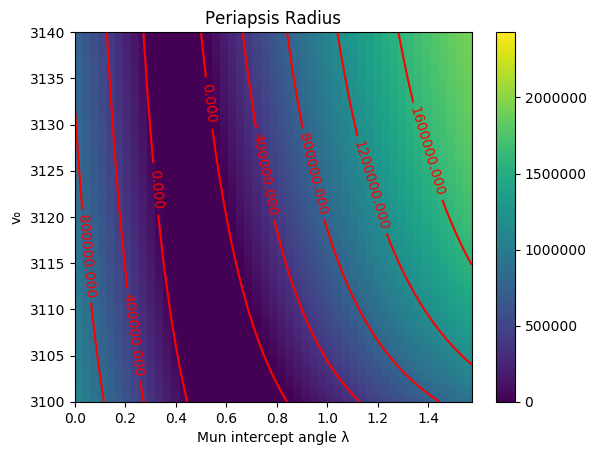

PyObject <matplotlib.text.Text object at 0x7f82eb5c9110>

In [11]:
vStart = 3100 #3080
vEnd = 3140   #3200
numV = 100
lambdaStart = 0
lambdaEnd = pi/2
numLambda = 50

#space across lambdas (mun intercept point angles) and v_0s
Λ,V = sampleSpace = meshgrid(linspace(lambdaStart,lambdaEnd,numLambda),
                             linspace(vStart,vEnd,numV))

#lunar periapsis radii at each λ, v point
#R = lunarDeflectionAngle.(lunarInterceptBate.(100000+kerbinRadius,V,0.00001,Λ))
R = lunarPeriapsis.(lunarInterceptBate.(100000+kerbinRadius,V,0,Λ))-munRadius

fig1 = figure()
  ax = fig1[:gca]()
p = pcolormesh(Λ, V, R, vmin=0, vmax=munSOI)
#p = pcolormesh(Λ, V, R, vmin = -pi, vmax =pi)
colorbar()
C = contour(Λ, V, R,6,colors="r")
clabel(C, inline=1, fontsize=10)
title("Periapsis Radius")
ylabel("v₀")
xlabel("Mun intercept angle λ")

To run get the ship to fly the right orbit:

`run tothemun.ks(7353189,5.8989,1400000).`
